# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendar

import warnings
warnings.filterwarnings('ignore')

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [8]:
df = pd.read_csv('../tables/flights_sample_small.csv')

In [9]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'origin_airport_id', 'origin',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance',
       'arr_delay'],
      dtype='object')

In [10]:
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0
1,2019-01-01,AA,5606,OH,N575NN,13577,MYR,"Myrtle Beach, SC",11057,CLT,"Charlotte, NC",2157,2311,74,157,-3.0
2,2019-01-01,AA,5607,OH,N254PS,10529,BDL,"Hartford, CT",11278,DCA,"Washington, DC",1151,1325,94,313,6.0
3,2019-01-01,AA,5607,OH,N254PS,11278,DCA,"Washington, DC",10529,BDL,"Hartford, CT",1009,1126,77,313,14.0
4,2019-01-01,AA,5608,OH,N710PS,11278,DCA,"Washington, DC",11996,GSP,"Greer, SC",2000,2134,94,396,-12.0


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

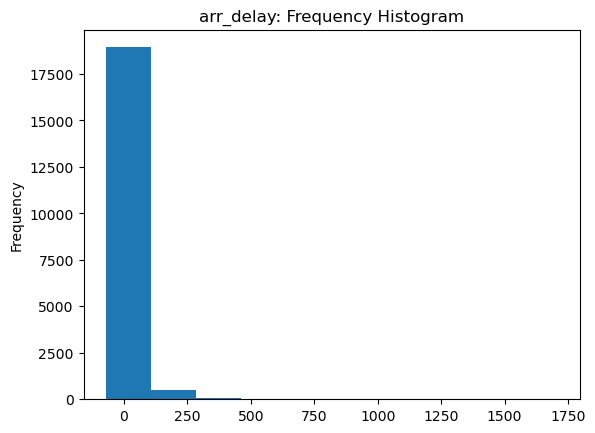

In [5]:
plt.hist(df['arr_delay'], bins=10)
plt.gca().set(title='arr_delay: Frequency Histogram', ylabel='Frequency');

<AxesSubplot:xlabel='arr_delay'>

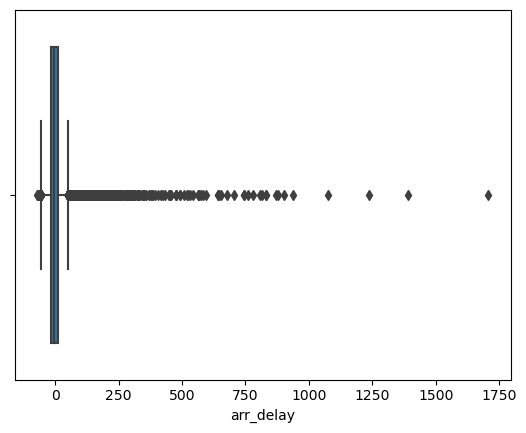

In [6]:
sns.boxplot(x=df['arr_delay'])

In [7]:
# Set Binary target variable. 
df['delay_yn'] = np.where(df['arr_delay'] <= 0, 0, 1)
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0,0
1,2019-01-01,AA,5606,OH,N575NN,13577,MYR,"Myrtle Beach, SC",11057,CLT,"Charlotte, NC",2157,2311,74,157,-3.0,0
2,2019-01-01,AA,5607,OH,N254PS,10529,BDL,"Hartford, CT",11278,DCA,"Washington, DC",1151,1325,94,313,6.0,1
3,2019-01-01,AA,5607,OH,N254PS,11278,DCA,"Washington, DC",10529,BDL,"Hartford, CT",1009,1126,77,313,14.0,1
4,2019-01-01,AA,5608,OH,N710PS,11278,DCA,"Washington, DC",11996,GSP,"Greer, SC",2000,2134,94,396,-12.0,0


In [8]:
def get_hour_from_int(x):
    if len(x) == 4:
        return int(x[:2])
    return int(x[0])

In [9]:
# # Get the month, and the hour of the flight
df['dep_hour'] = df['crs_dep_time'].map(str).apply(lambda x: get_hour_from_int(x))
df['arr_hour'] = df['crs_arr_time'].map(str).apply(lambda x: get_hour_from_int(x))
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn,dep_hour,arr_hour
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0,0,6,9
1,2019-01-01,AA,5606,OH,N575NN,13577,MYR,"Myrtle Beach, SC",11057,CLT,"Charlotte, NC",2157,2311,74,157,-3.0,0,21,23
2,2019-01-01,AA,5607,OH,N254PS,10529,BDL,"Hartford, CT",11278,DCA,"Washington, DC",1151,1325,94,313,6.0,1,11,13
3,2019-01-01,AA,5607,OH,N254PS,11278,DCA,"Washington, DC",10529,BDL,"Hartford, CT",1009,1126,77,313,14.0,1,10,11
4,2019-01-01,AA,5608,OH,N710PS,11278,DCA,"Washington, DC",11996,GSP,"Greer, SC",2000,2134,94,396,-12.0,0,20,21


In [11]:
df['fl_date'] = df['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [12]:
# holiday_cal
cal = holiday_calendar()
dr = df['fl_date'] 
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['fl_date'].dt.date.astype('datetime64').isin(holidays).astype(int)
df.tail(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn,dep_hour,arr_hour,holiday
19517,2019-01-01,DL,830,DL,N909DA,10397,ATL,"Atlanta, GA",11066,CMH,"Columbus, OH",1903,2033,90,447,-9.0,0,19,20,1
19518,2019-01-01,DL,831,DL,N344NW,11278,DCA,"Washington, DC",13487,MSP,"Minneapolis, MN",1656,1857,181,931,-24.0,0,16,18,1
19519,2019-01-01,DL,832,DL,N659DL,14869,SLC,"Salt Lake City, UT",11278,DCA,"Washington, DC",932,1532,240,1851,-18.0,0,9,15,1
19520,2019-01-01,DL,833,DL,N365DN,11433,DTW,"Detroit, MI",14679,SAN,"San Diego, CA",830,1047,317,1956,-25.0,0,8,10,1
19521,2019-01-01,DL,833,DL,N365DN,14679,SAN,"San Diego, CA",11433,DTW,"Detroit, MI",1152,1920,268,1956,-24.0,0,11,19,1


In [13]:
df['dep_day_of_week'] = df['fl_date'].dt.day_name()

In [14]:
df_encoded = pd.get_dummies(data=df, columns=['mkt_unique_carrier'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['dep_day_of_week'], drop_first=False)
# df_encoded['dep_day_of_week_Monday'].dtype
df_encoded.columns

Index(['fl_date', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'distance', 'arr_delay', 'delay_yn', 'dep_hour',
       'arr_hour', 'holiday', 'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_WN',
       'dep_day_of_week_Tuesday'],
      dtype='object')

In [16]:
df.isna().sum()

fl_date                0
mkt_unique_carrier     0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
crs_arr_time           0
crs_elapsed_time       0
distance               0
arr_delay             28
delay_yn               0
dep_hour               0
arr_hour               0
holiday                0
dep_day_of_week        0
dtype: int64

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']

numeric_df = df_encoded.select_dtypes(include=numerics)
numeric_df.columns

Index(['mkt_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance',
       'arr_delay', 'delay_yn', 'dep_hour', 'arr_hour', 'holiday',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_WN',
       'dep_day_of_week_Tuesday'],
      dtype='object')

In [19]:
X = df_encoded[['crs_elapsed_time', 'distance',
       'holiday', 'dep_hour', 'arr_hour',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_WN',
       'dep_day_of_week_Tuesday']]
y = df_encoded['delay_yn']
feature_list = list(X.columns)
X.head(5)

,crs_elapsed_time,distance,holiday,dep_hour,arr_hour,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_WN,dep_day_of_week_Tuesday
0,156,815,1,6,9,1,0,0,0,0,0,0,0,0,0,1
1,74,157,1,21,23,1,0,0,0,0,0,0,0,0,0,1
2,94,313,1,11,13,1,0,0,0,0,0,0,0,0,0,1
3,77,313,1,10,11,1,0,0,0,0,0,0,0,0,0,1
4,94,396,1,20,21,1,0,0,0,0,0,0,0,0,0,1


### PCA

Text(0, 0.5, '% Cumulative explained variance')

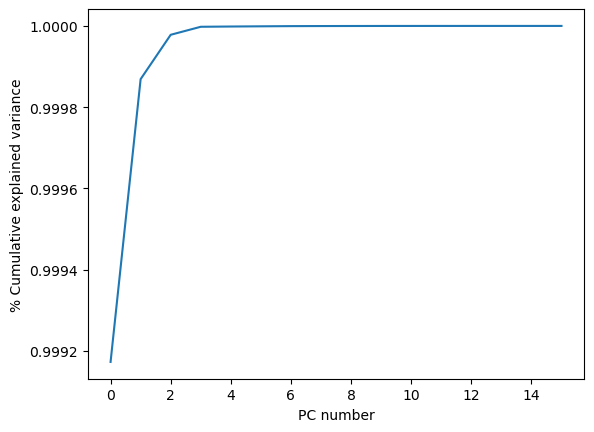

In [20]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

In [21]:
# 3 principal components (three-dimensional space)
pca = PCA(n_components=3)

In [22]:
# pca transformation
pca_df = pd.DataFrame(pca.fit_transform(X), columns = ['PC1', 'PC2', 'PC3'])

In [23]:
pca_df

,PC1,PC2,PC3
0,4.390423,-11.549145,9.095430
1,-658.698945,-8.636862,-11.186256
2,-501.423434,-10.094601,2.887726
3,-503.463585,6.738467,5.412827
4,-419.025924,0.155615,-8.888243
...,...,...,...
19517,-368.874414,10.211226,-7.251646
19518,122.549807,-22.114438,-4.564111
19519,1042.982132,29.504079,3.392632
19520,1156.465545,-34.353024,6.273066


### Splitting training and testing data

In [25]:
from sklearn.model_selection import train_test_split

In [24]:
# Split the data into target and independent variables
X = df[['distance','crs_elapsed_time','holiday','dep_hour','arr_hour']]
y = df['delay_yn']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train.drop(['fl_date', 'mkt_carrier_fl_num', 'origin', 'dest'], axis=1)

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

Let's try random forest regression with default settings as a benchmark

In [27]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
rcv = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs=12)

In [31]:
rcv.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  12.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  14.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   7.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  12.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  12.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  15.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=12,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [32]:
rcv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [36]:
# n_scores = cross_val_score(rcv, X_train, y_train, scoring='neg_mean_absolute_error', n_jobs=12, error_score='raise')
# # report performance
# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  58.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  50.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  13.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  46.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  17.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.3s
[CV] END bootstrap=True, max_depth=2

KeyboardInterrupt: 

In [37]:
model = RandomForestRegressor(n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10, bootstrap=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=1600)

In [39]:
y_pred = model.predict(X_test)

In [40]:
from sklearn.metrics import r2_score

In [41]:
r2_score(y_test, y_pred)

0.027078110254096455

In [42]:
import pickle
pickle.dump(model, open('randomforest_model.sav', 'wb'))

In [43]:
print ("Features sorted by their score:")
names = X_train.columns
print (sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.3604, 'distance'), (0.3001, 'crs_elapsed_time'), (0.1801, 'dep_hour'), (0.1593, 'arr_hour'), (0.0, 'holiday')]


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.